In [18]:
!pip install tensorflow

In [19]:
# Install Kaggle
!pip install -q kaggle

# Upload kaggle.json (you need to do this manually by clicking in the file upload prompt)
from google.colab import files
files.upload()  # upload your kaggle.json here

# Set permission and move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the osteoporosis dataset by stevepython
!kaggle datasets download -d mohamedgobara/osteoporosis-database
!kaggle datasets download -d stevepython/osteoporosis-knee-xray-dataset


# Unzip the dataset
!unzip -q osteoporosis-knee-xray-dataset.zip


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mohamedgobara/osteoporosis-database
License(s): Community Data License Agreement - Sharing - Version 1.0
osteoporosis-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/stevepython/osteoporosis-knee-xray-dataset
License(s): unknown
osteoporosis-knee-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
!unzip -q osteoporosis-database.zip

replace Osteoporosis Knee X-ray/normal/N1.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
!ls -l

total 472416
drwxr-xr-x 4 root root      4096 May 28 16:44  dataset
-rw-r--r-- 1 root root        67 May 28 16:47 'kaggle (1).json'
-rw-r--r-- 1 root root        67 May 28 16:36  kaggle.json
drwxr-xr-x 3 root root      4096 May 28 16:47  normal
drwxr-xr-x 3 root root      4096 May 28 16:47  osteoporosis
-rw-r--r-- 1 root root 190537183 Oct 25  2023  osteoporosis-database.zip
drwxr-xr-x 5 root root      4096 May 28 16:38 'Osteoporosis Knee X-ray'
-rw-r--r-- 1 root root 293187424 Sep 27  2021  osteoporosis-knee-xray-dataset.zip
drwxr-xr-x 1 root root      4096 May 23 13:39  sample_data


In [22]:
# Create dataset folder
!mkdir dataset

# Move class folders inside dataset/
!mv normal dataset/
!mv osteoporosis dataset/


mkdir: cannot create directory ‘dataset’: File exists
mv: cannot move 'normal' to 'dataset/normal': Directory not empty
mv: cannot move 'osteoporosis' to 'dataset/osteoporosis': Directory not empty


In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [24]:
BATCH_SIZE = 24
IMAGE_SIZE =256
CHANNELS=3
EPOCHS=30

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 372 files belonging to 2 classes.


In [26]:
len(dataset)

16

In [27]:
class_names = dataset.class_names
class_names

['normal', 'osteoporosis']

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (24, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (24, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (24, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (24, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (24, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (24, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (24, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (24, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (24, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (24, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (24, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (24, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (24, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (24, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (24, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (24, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.5044 - loss: 0.6954 - val_accuracy: 0.7083 - val_loss: 0.6856
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5995 - loss: 0.6866 - val_accuracy: 0.6667 - val_loss: 0.6535
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5770 - loss: 0.6801 - val_accuracy: 0.6250 - val_loss: 0.6095
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6331 - loss: 0.6366 - val_accuracy: 0.5000 - val_loss: 0.7016
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6155 - loss: 0.6370 - val_accuracy: 0.7917 - val_loss: 0.5585
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7189 - loss: 0.5679 - val_accuracy: 0.8333 - val_loss: 0.5077
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7275 - loss: 0.4993 - val_accuracy: 0.8333 - val_loss: 0.4928
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8089 - loss: 0.4402 - val_accuracy: 0.8333 - val_loss:

In [36]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 756ms/step - accuracy: 0.9219 - loss: 0.2328


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

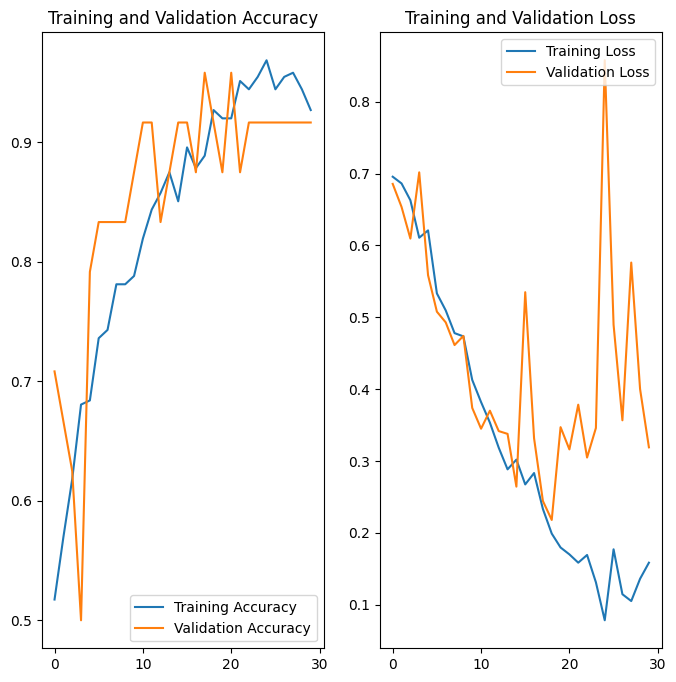

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [40]:
import numpy as np


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


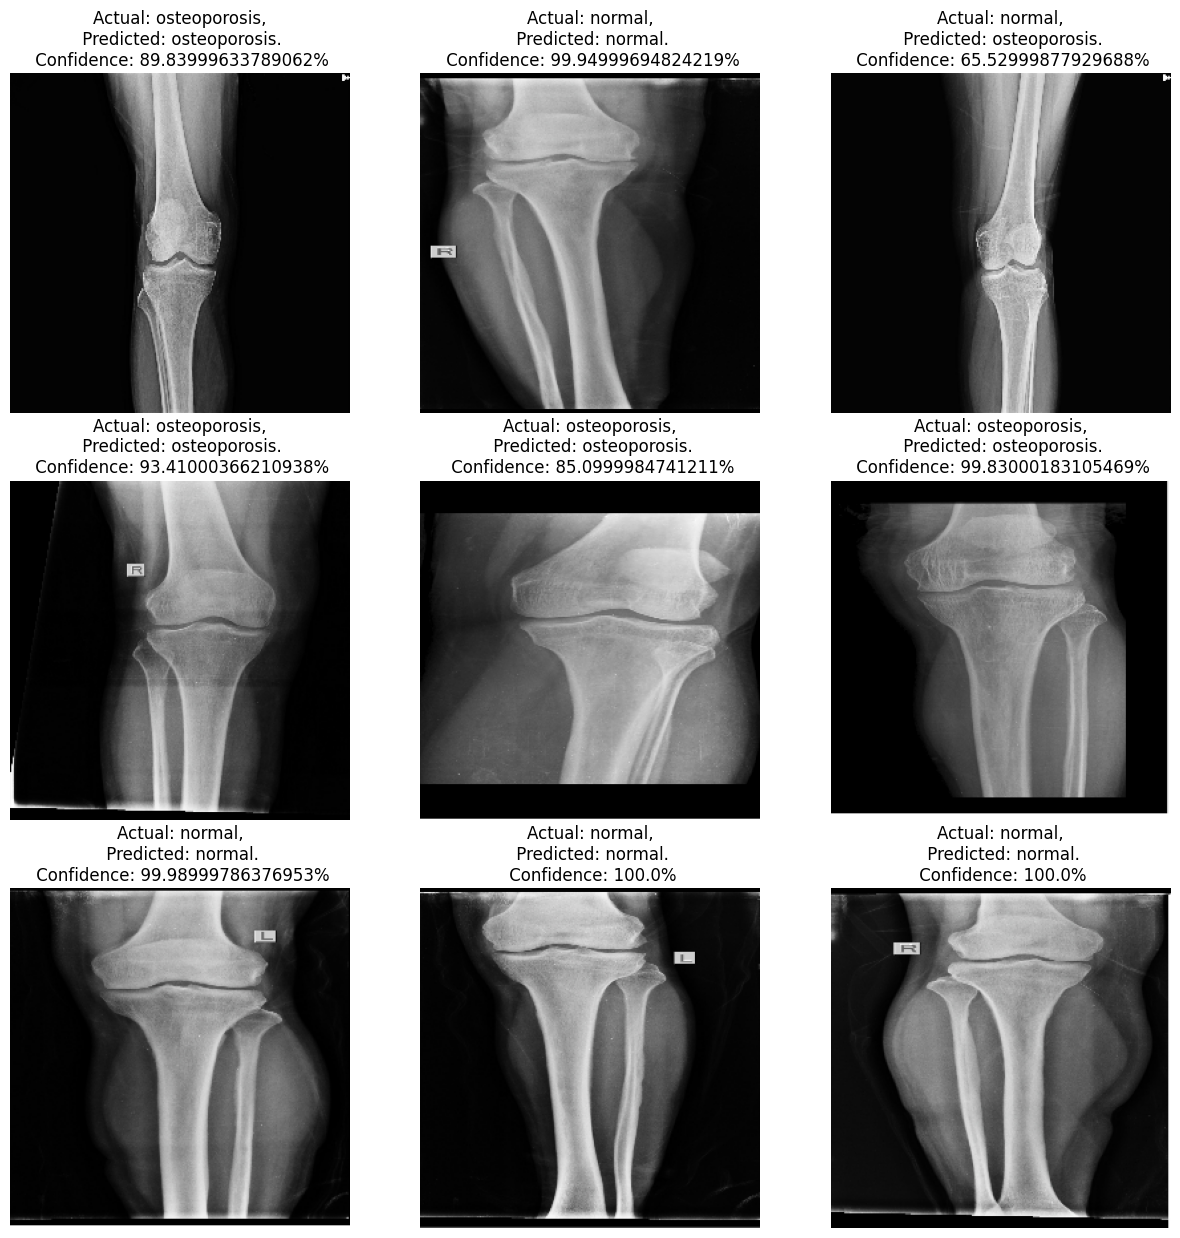

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming val_ds returns (images, labels)
y_true = np.concatenate([labels for _, labels in val_ds])
y_pred = np.argmax(model.predict(val_ds), axis=1)

print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.92      0.92      0.92        12

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[11  1]
 [ 1 11]]


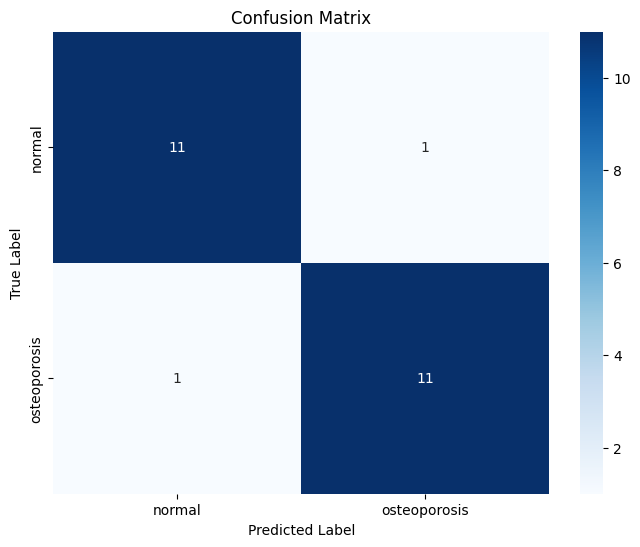

In [46]:
# prompt: print the confusion matrix for the model

import matplotlib.pyplot as plt
import numpy as np
# Generate predictions on the validation dataset
y_pred_val = np.argmax(model.predict(val_ds), axis=1)

# Get true labels from the validation dataset
y_true_val = np.concatenate([labels for _, labels in val_ds])

# Compute the confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Display the confusion matrix with labels (requires seaborn and matplotlib)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()